# Circuits in Quantum Algorithms

Qiskit Circuit session, July 22nd, 2020

## What's a quantum algorithm?

Algorithms that run some part on a quantum computer. Here running on a quantum computer means running a circuit.

![](quantum_algo.png)

Today we'll focus on the circuit part, using Qiskit's circuit library.

![](quantum_algo_focus.png)

## Recap: The circuit library

Library of interesting families of circuits. 

Interesting?
For algorithms, eduction and complexity analysis

Further material:
* `qiskit.circuit.library` 
* qiskit.org/documentation/apidoc/circuit_library.html
* Interactive overview: qisk.it/circuits
* See also previous session with Ali Javadi

Seen how to import circuits from the library:

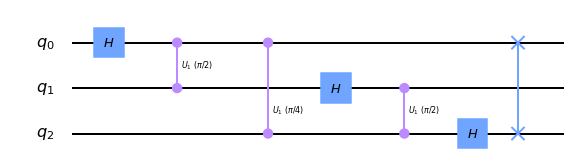

In [9]:
from qiskit.circuit.library import QFT

QFT(3).draw(output='mpl')

Seen they might have a couple of options.

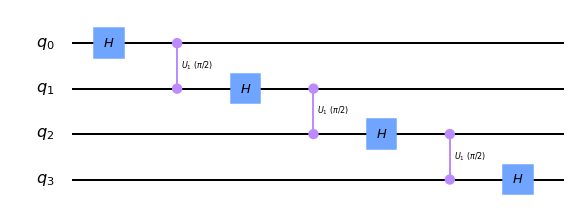

In [10]:
QFT(4, approximation_degree=2, do_swaps=False).draw(output='mpl')

Seen that they are normal circuits.

Non-local gates: 4
Operations: OrderedDict([('h', 3), ('cu1', 3), ('swap', 1)])


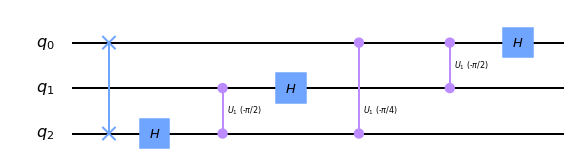

In [11]:
qft = QFT(3)
print('Non-local gates:', qft.num_nonlocal_gates())
print('Operations:', qft.count_ops())
qft.inverse().draw(output='mpl')

It's easy to stack them together. Remember the `compose` method:
```
QuantumCircuit.compose(circuit, qubits=None, inplace=False) 
```

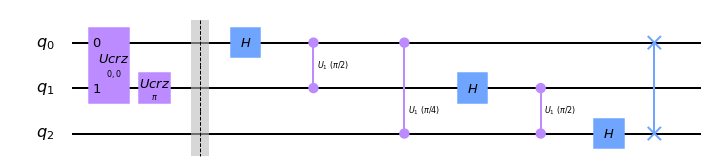

In [12]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import Diagonal

circuit = QuantumCircuit(3)
circuit.compose(Diagonal([1, 1, -1, -1]), [0, 1], inplace=True)
circuit.barrier()  # barrier for visualization purposes
circuit.compose(QFT(3), inplace=True)
circuit.draw(output='mpl')

## Overview

Let's have a look what circuits are in the circuit library.

![overview](overview.png)

## Workflow

How do we as users, researchers or developers want to use these circuits?

![](quantum_algo_circlib.png)

### Example: Variational Quantum Classifier

![](quantum_algo_vqc.png)

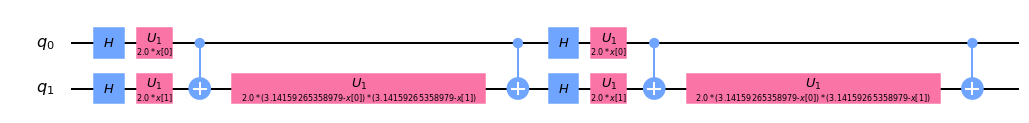

In [13]:
from qiskit.circuit.library.data_preparation import ZZFeatureMap  # can also drop .data_preparation
from qiskit.circuit.library.n_local import RealAmplitudes  # can also drop .n_local

data_preparation = ZZFeatureMap(2)
data_preparation.draw(output='mpl')

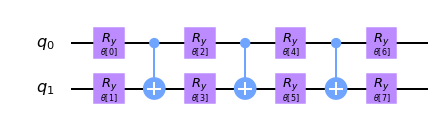

In [14]:
classifier = RealAmplitudes(2)
classifier.draw(output='mpl')

In [7]:
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.ml.datasets import ad_hoc_data

In [1]:
_, training_data, test_data, _ = ad_hoc_data(10, 10, 2, 0.2)
optimizer = SPSA(maxiter=100)
vqc = VQC(optimizer, data_preparation, classifier, training_data)

NameError: name 'ad_hoc_data' is not defined

In [9]:
from qiskit import Aer
backend = Aer.get_backend('qasm_simulator')

result = vqc.run(backend)
print('Loss:', result['training_loss'])

Loss: 0.23919843187372664


## Circuits in Algorithms

![](algo_overview.png)

## Parameterized quantum circuits

Give example for which ones used... Maxcut -> real amplitudes, chemistry -> complex. But chemistry also others... like classically motivated ones such as UCCSD.

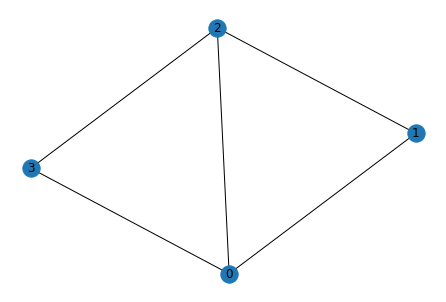

In [12]:
import networkx as nx

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
graph.add_weighted_edges_from(elist)

nx.draw(graph, with_labels=True)

Expect 0101 (or 1010, since symmetric problem)

In [ ]:
nx.draw(graph, with_labels=True, node_color=[0, 1, 0, 1])

Quantum optimization using variational algorithms
on near-term quantum devices, Moll et al. [arXiv:1710.01022](https://arxiv.org/pdf/1710.01022.pdf)

In [ ]:
from qiskit.aqua.operators import Z, I

# ising = (Z ^ Z ^ I ^ I) + (Z ^ I ^ Z ^ I) + (Z ^ I ^ I ^ Z) + (I ^ Z ^ Z ^ I)
ising = (I ^ I ^ Z ^ Z) + (I ^ Z ^ I ^ Z) + (Z ^ I ^ I ^ Z) + (I ^ Z ^ Z ^ I)

Which Ansatz? Ideally, we have full access to the subspace of possible solutions. Here, we e.g. don't need complex amplitudes.

In [ ]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=3)
ansatz.draw(output='mpl')

Why is it called `RealAmplitudes`? It has only real amplitudes! RY does not apply complex amplitudes and neither does CX.

In [ ]:
bound_ansatz = ansatz.assign_parameters(np.random.random(ansatz.num_parameters))
Statevector.from_instruction(bound_ansatz)

Let's run the algorithm!

In [ ]:
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import SPSA, COBYLA

optimizer = SPSA()
ansatz = RealAmplitudes(reps=1)

vqe = VQE(ising, ansatz, optimizer)#, include_custom=True)
result = vqe.run(Aer.get_backend('qasm_simulator'))
print('Minimal energy at:', result.eigenstate)

In [ ]:
from qiskit.visualization import plot_histogram
plot_histogram(result.eigenstate)

We can also choose others, but they have more parameters and are more difficult to optimize since they have more parameters!

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(3)
ansatz.draw(output='mpl')

In [ ]:
bound_ansatz = ansatz.assign_parameters(np.random.random(ansatz.num_parameters))
Statevector.from_instruction(bound_ansatz)

In [ ]:
vqe = VQE(ising, EfficientSU2(), optimizer)
result = vqe.run(Aer.get_backend('qasm_simulator'))
plot_histogram(result.eigenstate)

### The `TwoLocal` circuit

Hardware efficient, quantum-native.

    TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, reps, entanglement)
    
    
[arXiv:1905.10876](https://arxiv.org/pdf/1905.10876.pdf)

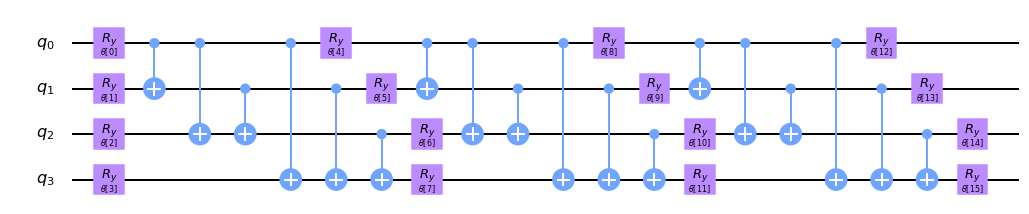

In [14]:
from qiskit.circuit.library import TwoLocal

two = TwoLocal(4, 'ry', 'cx')
two.draw(output='mpl')

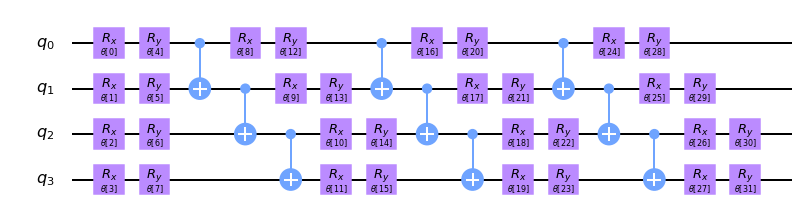

In [15]:
two = TwoLocal(4, ['rx', 'ry'], 'cx', entanglement='linear')
two.draw(output='mpl')

Circuit 6 in [arXiv:1905.10876](https://arxiv.org/pdf/1905.10876.pdf)

![](circuit6.png)

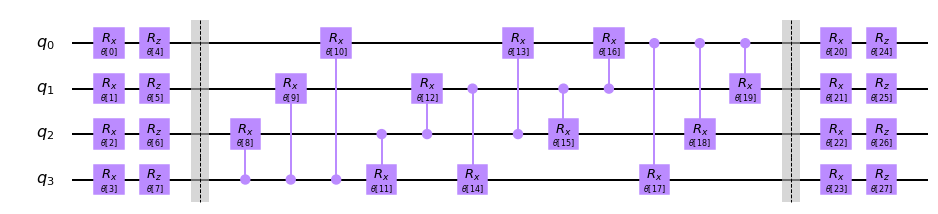

In [16]:
entanglement = [(3, 2), (3, 1), (3, 0),
                (2, 3), (2, 1), (2, 0),
                (1, 3), (1, 2), (1, 0),
                (0, 3), (0, 2), (0, 1)]
two = TwoLocal(4, ['rx', 'rz'], 'crx', entanglement=entanglement, reps=1, insert_barriers=True)
two.draw(output='mpl')

In [ ]:
vqe = VQE(ising, two, SPSA())
result = vqe.run(Aer.get_backend('qasm_simulator'))
plot_histogram(result.eigenstate)

If you come up with your own good ansatz, add it to the library!

E.g. we want our own circuit, say:

In [15]:
from qiskit.circuit import QuantumCircuit, ParameterVector

ansatz = QuantumCircuit(4)

p = ParameterVector('p', 16)
p_iter = iter(p)

for i in range(4):
    ansatz.ry(next(p_iter), i)
ansatz.append(QFT(4, approximation_degree=1, do_swaps=False), [0, 1, 2, 3])
for i in range(4):
    ansatz.ry(next(p_iter), i)   
ansatz.append(QFT(4, approximation_degree=1, do_swaps=False).inverse(), [0, 1, 2, 3])
for i in range(4):
    ansatz.ry(next(p_iter), i)  

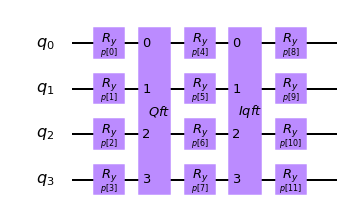

In [18]:
ansatz.draw(output='mpl')

In [ ]:
vqe = VQE(ising, ansatz, optimizer)
result = vqe.run(Aer.get_backend('qasm_simulator'))
plot_histogram(result.eigenstate)

### Summary

* Choose the right Ansatz for your application
* Circuit library offers a set of standard varforms (like `RealAmplitudes`) and tools to build new ones (`TwoLocal`)
* Algorithms can use individual circuits as input

## Chemistry applications

Need varform with complex amplitudes, since we now represent wave functions of molecules which might have complex amplitudes. So `RealAmplitudes` is not the right. 
Could use `EfficientSU2` -- > complex states.

In [105]:
ansatz = EfficientSU2()

In [118]:
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

In [183]:
# run H2 molecule
from qiskit.aqua.operators import I, Z, X
from qiskit.aqua.components.optimizers import L_BFGS_B

h2_op = -1.052373245772859 * (I ^ I) + 0.39793742484318045 * (I ^ Z) \
        - 0.39793742484318045 * (Z ^ I) - 0.01128010425623538 * (Z ^ Z) \
        + 0.18093119978423156 * (X ^ X)
h2_energy = -1.85727503

optimizer = L_BFGS_B()

backend = Aer.get_backend('qasm_simulator')

vqe = VQE(h2_op, ansatz, optimizer)
res = vqe.run(backend)
res.eigenvalue.real

-1.062946587529937

### Another approach: Classically motivated

In chemistry, the UCCSD(T) method is considered the "gold" standard to compute the ground state energy.
This also uses the variational principle with a certain wavefunction ansatz. 
We can also use this wavefunction here! It looks like this
[panos paper]

Let's compare circuit sizes though....

* number of parameters increases significantly with the number of elections (bad scaling to larger systems)
* long circuits
* circuits ignorant of hardware structure

In [21]:
from qiskit.chemistry.components.variational_forms import UCCSD

In [186]:
ucc = UCCSD(4, 2, reps=3)
p = ParameterVector('p', ucc.num_parameters)
ansatz = ucc.construct_circuit(p).decompose()
print(ansatz.decompose().depth(), circ.num_parameters, circ.num_qubits)
print(ansatz.decompose())

39 92 10
     ┌─────────────────────┐┌───────────────────┐┌──────────────────────┐»
q_0: ┤ U3(pi/2,-pi/2,pi/2) ├┤ U3(0,0,-2.0*p[0]) ├┤ U3(-pi/2,-pi/2,pi/2) ├»
     ├─────────────────────┤└┬──────────────────┤├──────────────────────┤»
q_1: ┤ U3(pi/2,-pi/2,pi/2) ├─┤ U3(0,0,2.0*p[1]) ├┤ U3(-pi/2,-pi/2,pi/2) ├»
     └─────────────────────┘ └──────────────────┘└──────────────────────┘»
«     ┌─────────────────────┐                               »
«q_0: ┤ U3(pi/2,-pi/2,pi/2) ├──■─────────────────────────■──»
«     └──┬───────────────┬──┘┌─┴─┐┌───────────────────┐┌─┴─┐»
«q_1: ───┤ U3(pi/2,0,pi) ├───┤ X ├┤ U3(0,0,-1.0*p[2]) ├┤ X ├»
«        └───────────────┘   └───┘└───────────────────┘└───┘»
«     ┌──────────────────────┐   ┌───────────────┐                            »
«q_0: ┤ U3(-pi/2,-pi/2,pi/2) ├───┤ U3(pi/2,0,pi) ├─────■──────────────────────»
«     └──┬───────────────┬───┘┌──┴───────────────┴──┐┌─┴─┐┌──────────────────┐»
«q_1: ───┤ U3(pi/2,0,pi) ├────┤ U3(pi/2,-pi/2,pi/2) ├┤ X ├┤ U3(0,0

In [187]:
vqe = VQE(h2_op, ansatz, optimizer)
res = vqe.run(backend)
res.eigenvalue.real

-1.1032215948736686

In [173]:
from qiskit.chemistry.drivers import PySCFDriver

H2 = 'H 0.0 0.0 0.0; H 0.0 0.0 0.735'
LiH = 'Li .0 .0 .0; H .0 .0 1.3'

def define_chemistry_problem(atom, basis, reduction=True):
    molecule = PySCFDriver(atom=atom, basis=basis).run()
    num_particles = molecule.num_alpha + molecule.num_beta
    num_orbitals = 2 * molecule.num_orbitals

    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type=mapping)

    if reduction:
        qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
        
    return qubitOp.to_opflow(), num_particles, num_orbitals

In [174]:
qubitOp, num_particles, num_orbitals = define_chemistry_problem(H2, 'sto3g')
print(qubitOp)

SummedOp(
[-1.052373245772859 * II,
0.39793742484318007 * IZ,
-0.39793742484318007 * ZI,
-0.01128010425623538 * ZZ,
0.18093119978423136 * XX])


In [177]:
num_orbitals, num_particles

(12, 4)

In [175]:
qubitOp, num_particles, num_orbitals = define_chemistry_problem(LiH, 'sto3g')
print(qubitOp)

SummedOp(
[-5.259038246818582 * IIIIIIIIII,
1.0235687911585036 * IIIIIIIIIZ,
-0.01771856623628656 * IIIIIIIIZX,
0.01771856623628656 * IIIIIIIIIX,
-0.02654806113115581 * IIIIIIIZXX,
-0.02654806113115581 * IIIIIIIIYY,
-0.004686977340277227 * IIIIIXXXXX,
-0.004686977340277227 * IIIIIYXXXY,
-0.1060833226130983 * IIIIIIIIZZ,
0.008011661921423425 * IIIIIIIZXZ,
-0.008011661921423425 * IIIIIIIIXI,
-0.005696482431937478 * IIIIIXXXXZ,
-0.005696482431937478 * IIIIIYXXYI,
-0.19442319698823987 * IIIIIIIZZI,
-0.014333639794327236 * IIIIIXXXZI,
-0.014333639794327236 * IIIIIYXYII,
-0.22447370517677553 * IIIIIIZZII,
-0.22447370517677542 * IIIIIZZIII,
-0.41689839336782997 * IIIIIZIIII,
1.0235687911585032 * IIIIZIIIII,
-0.017718566236286547 * IIIZXIIIII,
0.017718566236286547 * IIIIXIIIII,
-0.026548061131155848 * IIZXXIIIII,
-0.026548061131155848 * IIIYYIIIII,
-0.004686977340277227 * XXXXXIIIII,
-0.004686977340277227 * YXXXYIIIII,
-0.10608332261309833 * IIIZZIIIII,
0.008011661921423434 * IIZXZIIIII,
-0.00

In [178]:
ansatz = UCCSD(num_orbitals, num_particles, two_qubit_reduction=reduction)
p = ParameterVector('p', ucc.num_parameters)
ansatz = ucc.construct_circuit(p).decompose()

print('#Qubits:', ansatz.num_qubits, 'Depth:', ansatz.depth(), '#Params:', ansatz.num_parameters)

#Qubits: 10 Depth: 8467 #Params: 92


## Middle ground?

Or: think in more detail about the application. We're working in second quantization meaning we want to know which orbitals are occupied and which are free. This get's mapped onto qubits e.g. with the Jordan-Wigner mapping. 
There a 0 state is associated with the electron not being in the orbital and 1 with it being in the orbital.
Since we cannot lose electrons, the sum of 0 and 1s in a state must stay the same.

Hence: Excitation-preserving.

$$
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & \cos & -\sin & 0 \\
    0 & \sin & \cos & 0 \\
    0 & 0 & 0 & 1
\end{pmatrix}
$$

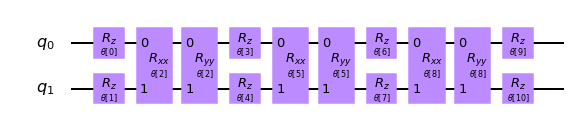

In [182]:
from qiskit.circuit.library import ExcitationPreserving

ansatz = ExcitationPreserving(2)
ansatz.draw(output='mpl')

Problem: JW mapping means no reduction, so Hamiltonian is larger

In [181]:
qubitOp, num_particles, num_orbitals = define_chemistry_problem(LiH, 'sto3g', reduction=False)
ansatz = ExcitationPreserving(qubitOp.num_qubits)
print('#Qubits:', ansatz.num_qubits, 'Depth:', ansatz.depth(), '#Params:', ansatz.num_parameters)

#Qubits: 12 Depth: 94 #Params: 246


## Quantum Fourier Transform

Used e.g. in Shor's algorithm or phase estimation. Let's see how easy it is to build the QPE algorithm.

In [191]:
from qiskit.circuit.library import QFT

unitary = QuantumCircuit(2, name='U')
unitary.x(0)
unitary.x(1)

bell1 = QuantumCircuit(2, name='psi')
bell1.x(0)
bell1.h(0)
bell1.cx(0, 1)

In [192]:
from qiskit.quantum_info import Statevector

before = Statevector.from_instruction(bell1)
after = before.evolve(unitary)
print('Before applying the unitary:\n', before)
print('After:\n', after)
print('Phase of -1?\n', all(after.data * -1 == before.data))

Before applying the unitary:
 Statevector([ 0.70710678+0.j,  0.        +0.j,  0.        +0.j,
             -0.70710678+0.j],
            dims=(2, 2))
After:
 Statevector([-0.70710678+0.j,  0.        +0.j,  0.        +0.j,
              0.70710678+0.j],
            dims=(2, 2))
Phase of -1?
 True


In [193]:
from qiskit.circuit import QuantumRegister

num_eval_qubits = 3

qr_eval = QuantumRegister(num_eval_qubits, 'eval')
qr_unitary = QuantumRegister(unitary.num_qubits, 'state')

circuit = QuantumCircuit(qr_eval, qr_unitary)

# start with eigenstate
circuit.append(bell1, qr_unitary[:])

# hadamards
circuit.h(qr_eval)

# controlled powers
for i in range(num_eval_qubits):
    controlled_power = unitary.power(2 ** i).control()
    circuit.compose(controlled_power, qubits=[i] + qr_unitary[:], inplace=True)
    
# inverse qft 
iqft = QFT(num_eval_qubits, do_swaps=False).inverse()

circuit.append(iqft, qr_eval[:])
# could also use compose but append wraps it so it's nicer to read
# circuit.compose(iqft, qubits=qr_eval, inplace=True)

In [194]:
# add measurements
from qiskit.circuit import ClassicalRegister

bits = ClassicalRegister(num_eval_qubits)
circuit.add_register(bits)
circuit.measure(qr_eval, bits)

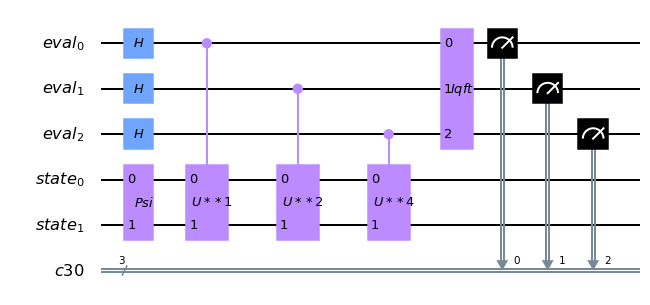

In [195]:
circuit.draw(output='mpl')

In [196]:
from qiskit import Aer, execute
backend = Aer.get_backend('qasm_simulator')
counts = execute(circuit, backend, shots=1024).result().get_counts()

In [197]:
counts

{'001': 1024}

Binary fraction: 
$$
    0.b_0 b_1 \dots = \frac{b_0}{2^1} + \frac{b_1}{2^2} + \cdots
$$
Means 
$$
    |001\rangle \rightarrow 0.100 = \frac{1}{2} + \frac{0}{4} + \frac{0}{8} = \frac{1}{2} = \varphi
$$

Thus we have the eigenvalue
$$
    \lambda = e^{2\pi i \varphi} = e^{\pi i} = -1
$$

If you ever get confused by Qiskit's ordering...

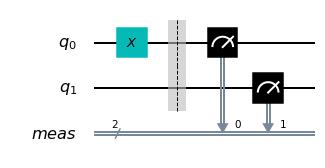

In [198]:
test = QuantumCircuit(2)
test.x(0)
test.measure_all()
test.draw(output='mpl')

In [199]:
counts = execute(test, backend).result().get_counts()
counts

{'01': 1024}

Could also just do this with the `PhaseEstimation` circuit from the library:

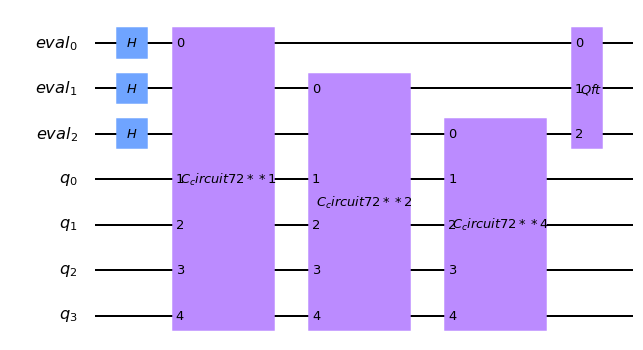

In [39]:
from qiskit.circuit.library import PhaseEstimation

pec = PhaseEstimation(3, unitary)
pec.draw(output='mpl')

## Contributing!

Missing:
* arithmetic circuits, like add 

## From Phase Estimation to Amplitude Estimation

In [19]:
from qiskit.circuit.library import LinearPauliRotations

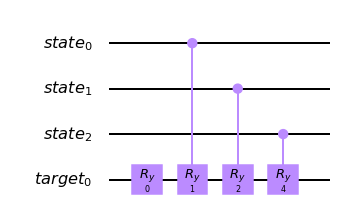

In [7]:
LinearPauliRotations(3, slope=1, offset=0).draw(output='mpl')

Can be used to map a function to qubit amplitudes. E.g.
$$
    f(x) = 2x - 1
$$

In [207]:
f = LinearPauliRotations(2, slope=2*2, offset=2*1)
equal_superpos = QuantumCircuit(3)
equal_superpos.h([0, 1])

sv = Statevector.from_label('000')
sv = sv.evolve(equal_superpos)
sv = sv.evolve(f)
sv.probabilities(qargs=[2])

array([0.48021114, 0.51978886])

In [168]:
y = 0.5
M = 2 ** num_probability_qubits
1 / M * sum((i / (M - 1) - y) ** 2 for i in range(M))

0.08870967741935484

In [172]:
num_probability_qubits = 3
uniform_distribution = QuantumCircuit(num_probability_qubits)
uniform_distribution.h(list(range(num_probability_qubits)))

slope = 2 / (2 ** num_probability_qubits - 1)
offset = -2 * y
linear_function = LinearPauliRotations(num_probability_qubits, slope, offset)

unitary = QuantumCircuit(num_probability_qubits + 1)
unitary.compose(uniform_distribution, qubits=list(range(num_probability_qubits)), inplace=True)
unitary.compose(linear_function, inplace=True)

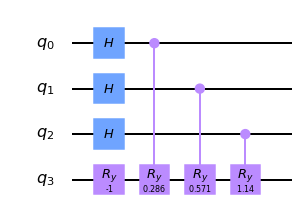

In [173]:
unitary.draw(output='mpl')

###  Building Q

In [175]:
S_psi_0 = QuantumCircuit(4)
S_psi_0.x(3)
S_psi_0.z(3)
S_psi_0.x(3)

In [176]:
from qiskit.circuit.library import ZGate

S_0 = QuantumCircuit(4)
S_0.x([0, 1, 2, 3])
S_0.append(ZGate().control(3), [0, 1, 2, 3])
S_0.x([0, 1, 2, 3])

In [198]:
Q = QuantumCircuit(4)
Q.compose(S_psi_0, inplace=True)
Q.barrier()
Q.compose(unitary.inverse(), inplace=True)
Q.barrier()
Q.compose(S_0, inplace=True)
Q.barrier()
Q.compose(unitary, inplace=True)

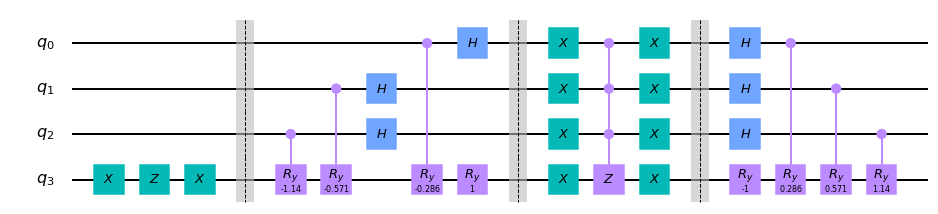

In [199]:
Q.draw(output='mpl')

In [200]:
Q = QuantumCircuit(4)
Q.compose(S_psi_0, inplace=True)
Q.compose(unitary.inverse(), inplace=True)
Q.compose(S_0, inplace=True)
Q.compose(unitary, inplace=True)

In [201]:
num_eval_qubits = 3
qae = QuantumCircuit(num_eval_qubits + num_probability_qubits + 1, num_eval_qubits)
qae.compose(unitary, qubits=[3, 4, 5, 6], inplace=True)
qae.compose(PhaseEstimation(3, Q), inplace=True)
qae.measure([0, 1, 2], [0, 1, 2])

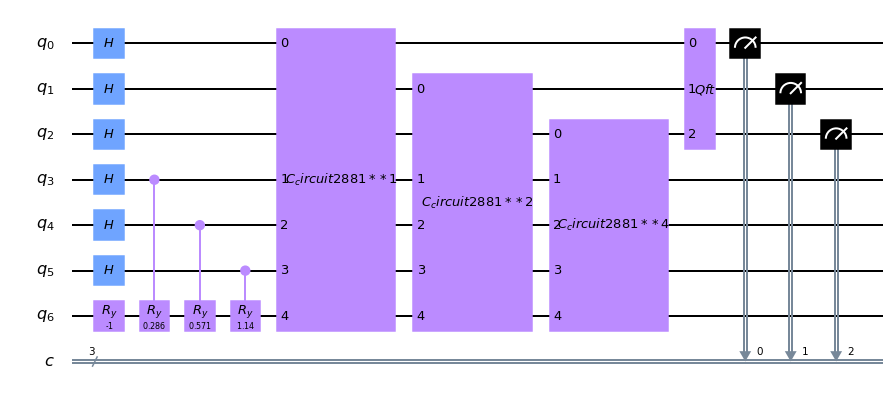

In [202]:
qae.draw(output='mpl')

In [181]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
import numpy as np

In [191]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qae, backend).result().get_counts()
print(counts)

{'000': 52, '001': 7, '010': 14, '011': 13, '100': 455, '101': 4, '110': 4, '111': 475}


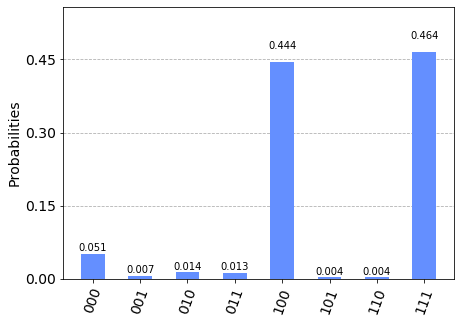

In [192]:
plot_histogram(counts)

In [193]:
most_likely = ''
max_count = 0
for state, count in counts.items():
    if count > max_count:
        most_likely = state
        max_count = count
        
print(most_likely)

111


In [194]:
M = 8

In [196]:
np.sin(np.pi * int(most_likely[::-1], 2) / 2 ** num_eval_qubits) ** 2

0.1464466094067263

In [139]:
print([np.sin(np.pi * i / M) ** 2 for i in range(int(M/2 + 1))])

[0.0, 0.14644660940672624, 0.4999999999999999, 0.8535533905932737, 1.0]
